# Examples

This Jupyter notebook shows some examples for the different functions of the Python module `zaf`.

Functions:
- [`stft`](#stft) - Compute the short-time Fourier transform (STFT).
- [`istft`](#istft) - Compute the inverse STFT.
- [`melfilterbank`](#melfilterbank) - Compute the mel filterbank.
- [`melspectrogram`](#melspectrogram) - Compute the mel spectrogram using a mel filterbank.
- [`mfcc`](#mfcc) - Compute the mel frequency cepstrum coefficients (MFCCs) using a mel filterbank.
- [`cqtkernel`](#cqtkernel) - Compute the constant-Q transform (CQT) kernel.
- [`cqtspectrogram`](#cqtspectrogram) - Compute the CQT spectrogram using a CQT kernel.
- [`cqtchromagram`](#cqtchromagram) - Compute the CQT chromagram using a CQT kernel.
- [`dct`](#dct) - Compute the discrete cosine transform (DCT) using the fast Fourier transform (FFT).
- [`dst`](#dst) - Compute the discrete sine transform (DST) using the FFT.
- [`mdct`](#mdct) - Compute the modified discrete cosine transform (MDCT) using the FFT.
- [`imdct`](#imdct) - Compute the inverse MDCT using the FFT.

Other:
- `wavread` - Read a WAVE file (using SciPy).
- `wavwrite` - Write a WAVE file (using SciPy).
- `sigplot` - Plot a signal in seconds.
- `specshow` - Display a spectrogram in dB, seconds, and Hz.
- `melspecshow` - Display a mel spectrogram in dB, seconds, and Hz.
- `mfccshow` - Display MFCCs in seconds.
- `cqtspecshow` - Display a CQT spectrogram in dB, seconds, and Hz.
- `cqtchromshow` - Display a CQT chromagram in seconds.


Author:
- Zafar Rafii
- zafarrafii@gmail.com
- http://zafarrafii.com
- https://github.com/zafarrafii
- https://www.linkedin.com/in/zafarrafii/
- 03/30/21

## <a id="stft"></a>stft

Compute the short-time Fourier transform (STFT).

```
audio_stft = zaf.stft(audio_signal, window_function, step_length)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
    step_length: step length in samples
Output:
    audio_stft: audio STFT (window_length, number_frames)
```

### Example: Compute and display the spectrogram from an audio file.

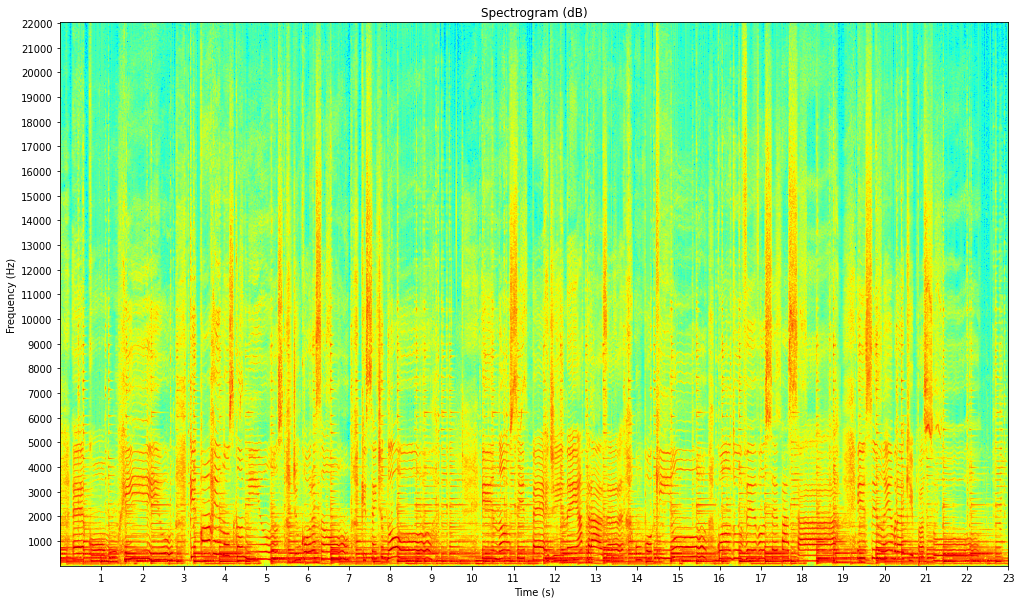

In [1]:
%matplotlib inline

# Import the needed modules
import numpy as np
import scipy.signal
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")
audio_signal = np.mean(audio_signal, 1)

# Set the window duration in seconds (audio is stationary around 40 milliseconds)
window_duration = 0.04

# Derive the window length in samples (use powers of 2 for faster FFT and constant overlap-add (COLA))
window_length = pow(2, int(np.ceil(np.log2(window_duration*sampling_frequency))))

# Compute the window function (use SciPy's periodic Hamming window for COLA as NumPy's Hamming window is symmetric)
window_function = scipy.signal.hamming(window_length, sym=False)

# Set the step length in samples (half of the window length for COLA)
step_length = int(window_length/2)

# Compute the STFT
audio_stft = zaf.stft(audio_signal, window_function, step_length)

# Derive the magnitude spectrogram (without the DC component and the mirrored frequencies)
audio_spectrogram = np.absolute(audio_stft[1:int(window_length/2)+1, :])

# Display the spectrogram in dB, seconds, and Hz
plt.figure(figsize=(17, 10))
zaf.specshow(audio_spectrogram, len(audio_signal), sampling_frequency, xtick_step=1, ytick_step=1000)
plt.title("Spectrogram (dB)")
plt.show()

## <a id="istft"></a>istft

Compute the inverse short-time Fourier transform (STFT).

```
audio_signal = zaf.istft(audio_stft, window_function, step_length)

Inputs:
    audio_stft: audio STFT (window_length, number_frames)
    window_function: window function (window_length,)
    step_length: step length in samples
Output:
    audio_signal: audio signal (number_samples,)
```

### Example: Estimate the center and the sides from a stereo audio file.

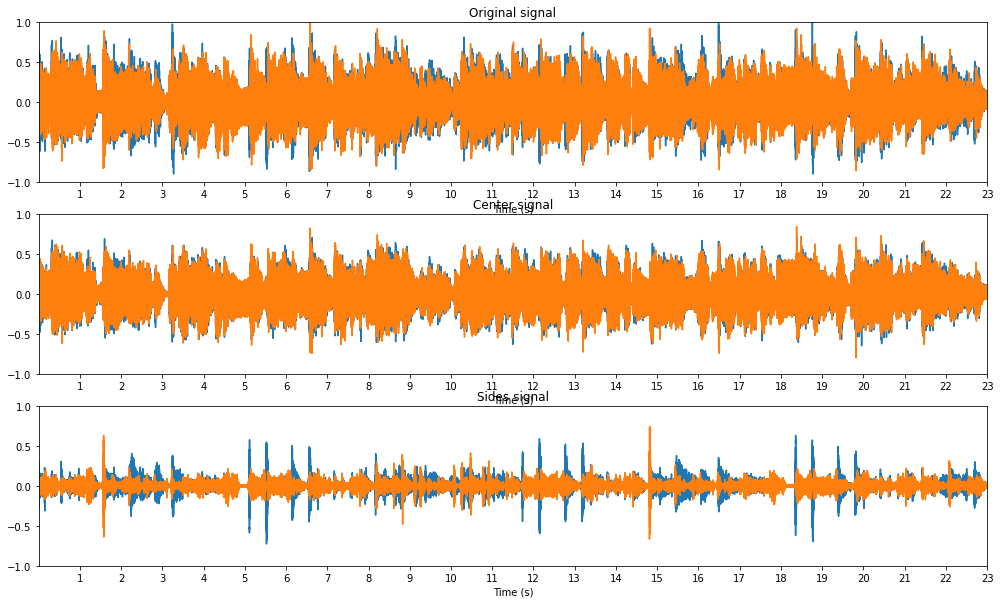

In [2]:
%matplotlib inline

# Import the needed modules
import numpy as np
import scipy.signal
import zaf
import matplotlib.pyplot as plt

# Read the (stereo) audio signal with its sampling frequency in Hz
audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")

# Set the parameters for the STFT
window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
window_function = scipy.signal.hamming(window_length, sym=False)
step_length = int(window_length/2)

# Compute the STFTs for the left and right channels
audio_stft1 = zaf.stft(audio_signal[:, 0], window_function, step_length)
audio_stft2 = zaf.stft(audio_signal[:, 1], window_function, step_length)

# Derive the magnitude spectrograms (with DC component) for the left and right channels
number_frequencies = int(window_length/2)+1
audio_spectrogram1 = abs(audio_stft1[0:number_frequencies, :])
audio_spectrogram2 = abs(audio_stft2[0:number_frequencies, :])

# Estimate the time-frequency masks for the left and right channels for the center
center_mask1 = np.minimum(audio_spectrogram1, audio_spectrogram2)/audio_spectrogram1
center_mask2 = np.minimum(audio_spectrogram1, audio_spectrogram2)/audio_spectrogram2

# Derive the STFTs for the left and right channels for the center (with mirrored frequencies)
center_stft1 = np.multiply(np.concatenate((center_mask1, center_mask1[-2:0:-1, :])), audio_stft1)
center_stft2 = np.multiply(np.concatenate((center_mask2, center_mask2[-2:0:-1, :])), audio_stft2)

# Synthesize the signals for the left and right channels for the center
center_signal1 = zaf.istft(center_stft1, window_function, step_length)
center_signal2 = zaf.istft(center_stft2, window_function, step_length)

# Derive the final stereo center and sides signals
center_signal = np.stack((center_signal1, center_signal2), axis=1)
center_signal = center_signal[0:np.shape(audio_signal)[0], :]
sides_signal = audio_signal-center_signal

# Write the center and sides signals
zaf.wavwrite(center_signal, sampling_frequency, "center_file.wav")
zaf.wavwrite(sides_signal, sampling_frequency, "sides_file.wav")

# Display the original, center, and sides signals in seconds
plt.figure(figsize=(17, 10))
plt.subplot(3, 1, 1),
zaf.sigplot(audio_signal, sampling_frequency, xtick_step=1)
plt.ylim(-1, 1), plt.title("Original signal")
plt.subplot(3, 1, 2)
zaf.sigplot(center_signal, sampling_frequency, xtick_step=1)
plt.ylim(-1, 1), plt.title("Center signal")
plt.subplot(3, 1, 3)
zaf.sigplot(sides_signal, sampling_frequency, xtick_step=1)
plt.ylim(-1, 1), plt.title("Sides signal")
plt.show()

## <a id="melfilterbank"></a>melfilterbank

Compute the mel filterbank.

```
mel_filterbank = zaf.melfilterbank(sampling_frequency, window_length, number_filters)

Inputs:
    sampling_frequency: sampling frequency in Hz
    window_length: window length for the Fourier analysis in samples
    number_mels: number of mel filters
Output:
    mel_filterbank: mel filterbank (number_mels, number_frequencies)
```

### Example: Compute and display a mel filterbank.

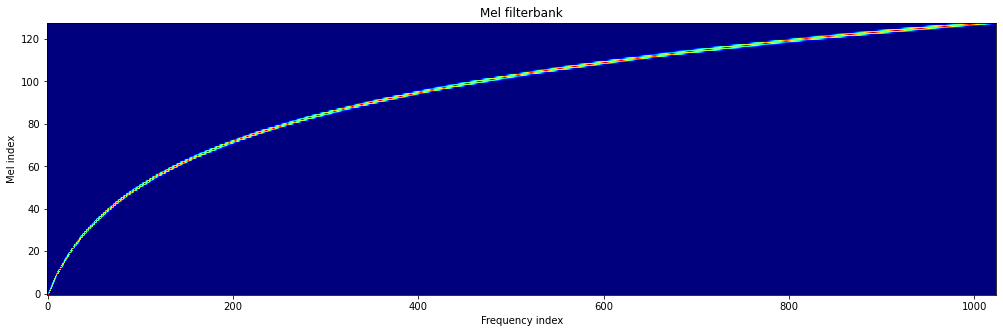

In [3]:
%matplotlib inline

# Import the needed modules
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Compute the mel filterbank using some parameters
sampling_frequency = 44100
window_length = pow(2, int(np.ceil(np.log2(0.04 * sampling_frequency))))
number_mels = 128
mel_filterbank = zaf.melfilterbank(sampling_frequency, window_length, number_mels)

# Display the mel filterbank
plt.figure(figsize=(17, 5))
plt.imshow(mel_filterbank.toarray(), aspect="auto", cmap="jet", origin="lower")
plt.title("Mel filterbank")
plt.xlabel("Frequency index")
plt.ylabel("Mel index")
plt.show()

## <a id="melspectrogram"></a>melspectrogram

Compute the mel spectrogram using a mel filterbank.

```
mel_spectrogram = zaf.melspectrogram(audio_signal, mel_filterbank)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
    step_length: step length in samples
    mel_filterbank: mel filterbank (number_mels, number_frequencies)
Output:
    mel_spectrogram: mel spectrogram (number_mels, number_times)
```

### Example: Compute and display the mel spectrogram.

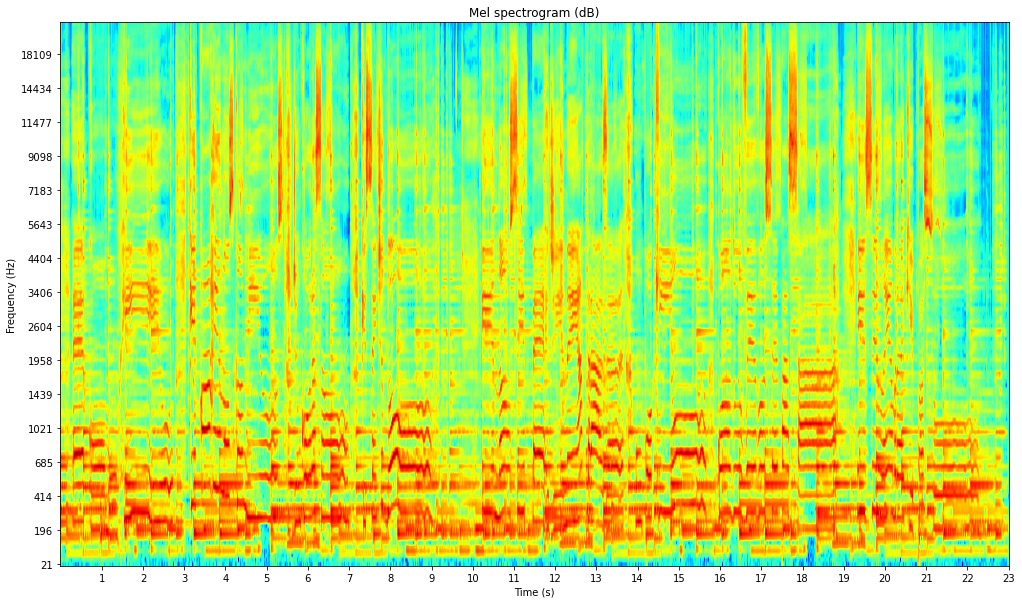

In [4]:
%matplotlib inline

# Import the needed modules
import numpy as np
import scipy.signal
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")
audio_signal = np.mean(audio_signal, 1)

# Set the parameters for the Fourier analysis
window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
window_function = scipy.signal.hamming(window_length, sym=False)
step_length = int(window_length/2)

# Compute the mel filterbank
number_mels = 128
mel_filterbank = zaf.melfilterbank(sampling_frequency, window_length, number_mels)

# Compute the mel spectrogram using the filterbank
mel_spectrogram = zaf.melspectrogram(audio_signal, window_function, step_length, mel_filterbank)

# Display the mel spectrogram in in dB, seconds, and Hz
plt.figure(figsize=(17, 10))
zaf.melspecshow(mel_spectrogram, len(audio_signal), sampling_frequency, window_length, xtick_step=1)
plt.title("Mel spectrogram (dB)")
plt.show()

## <a id="mfcc"></a>mfcc

Compute the mel frequency cepstrum coefficients (MFCCs) using a mel filterbank.

```
audio_mfcc = zaf.mfcc(audio_signal, window_function, step_length, mel_filterbank, number_coefficients)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
    step_length: step length in samples
    mel_filterbank: mel filterbank (number_mels, number_frequencies)
    number_coefficients: number of coefficients (without the 0th coefficient)
Output:
    audio_mfcc: audio MFCCs (number_times, number_coefficients)
```

### Example: Compute and display the MFCCs, delta MFCCs, and delta-delta MFCCs.

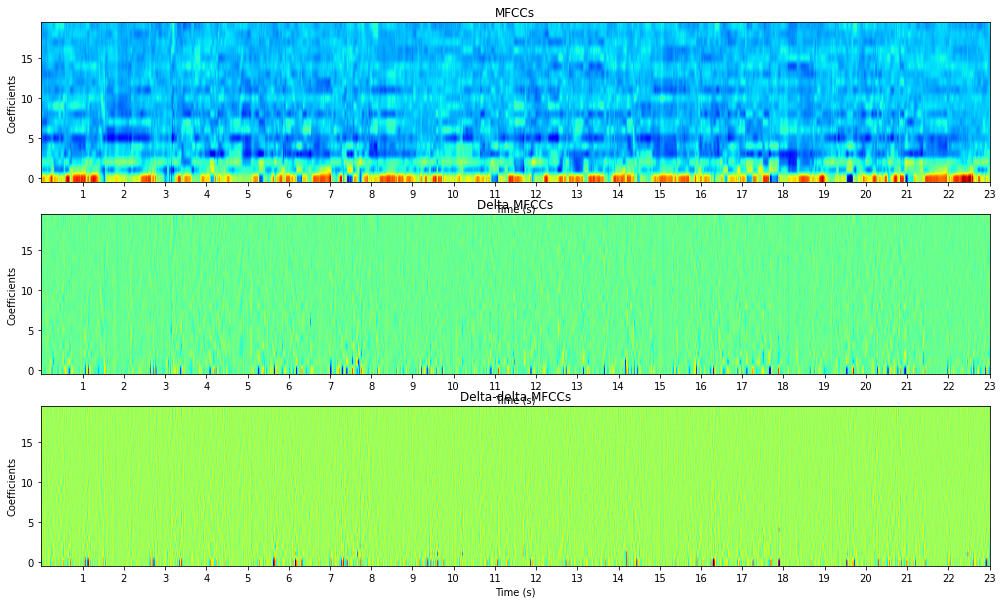

In [1]:
%matplotlib inline

# Import the needed modules
import numpy as np
import scipy.signal
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")
audio_signal = np.mean(audio_signal, 1)

# Set the parameters for the Fourier analysis
window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
window_function = scipy.signal.hamming(window_length, sym=False)
step_length = int(window_length/2)

# Compute the mel filterbank
number_mels = 40
mel_filterbank = zaf.melfilterbank(sampling_frequency, window_length, number_mels)

# Compute the MFCCs using the filterbank
number_coefficients = 20
audio_mfcc = zaf.mfcc(audio_signal, window_function, step_length, mel_filterbank, number_coefficients)

# Compute the delta and delta-delta MFCCs
audio_dmfcc = np.diff(audio_mfcc, n=1, axis=1)
audio_ddmfcc = np.diff(audio_dmfcc, n=1, axis=1)

# Display the MFCCs, delta MFCCs, and delta-delta MFCCs in seconds
plt.figure(figsize=(17, 10))
plt.subplot(3, 1, 1)
zaf.mfccshow(audio_mfcc, len(audio_signal), sampling_frequency, xtick_step=1), plt.title("MFCCs")
plt.subplot(3, 1, 2)
zaf.mfccshow(audio_dmfcc, len(audio_signal), sampling_frequency, xtick_step=1), plt.title("Delta MFCCs")
plt.subplot(3, 1, 3)
zaf.mfccshow(audio_ddmfcc, len(audio_signal), sampling_frequency, xtick_step=1), plt.title("Delta-delta MFCCs")
plt.show()

## <a id="cqtkernel"></a>cqtkernel

Compute the constant-Q transform (CQT) kernel.

```
cqt_kernel = zaf.cqtkernel(sampling_frequency, octave_resolution, minimum_frequency, maximum_frequency)

Inputs:
    sampling_frequency: sampling frequency in Hz
    octave_resolution: number of frequency channels per octave
    minimum_frequency: minimum frequency in Hz
    maximum_frequency: maximum frequency in Hz
Output:
    cqt_kernel: CQT kernel (sparse) (number_frequencies, fft_length)
```

### Example: Compute and display a CQT kernel.

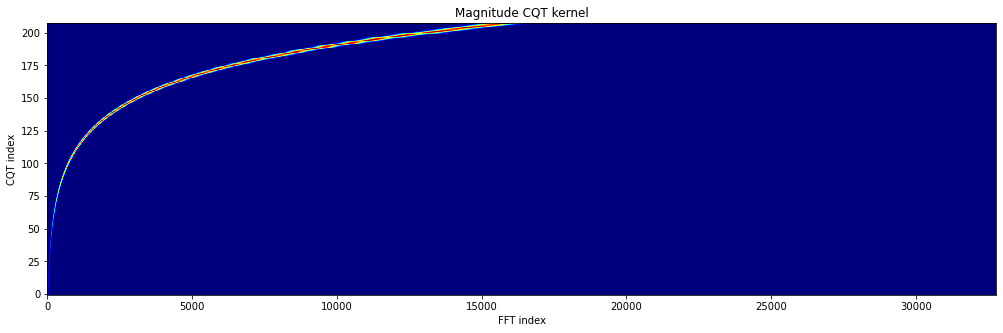

In [6]:
%matplotlib inline

# Import the needed modules
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Set the parameters for the CQT kernel
sampling_frequency = 44100
octave_resolution = 24
minimum_frequency = 55
maximum_frequency = sampling_frequency/2

# Compute the CQT kernel
cqt_kernel = zaf.cqtkernel(sampling_frequency, octave_resolution, minimum_frequency, maximum_frequency)

# Display the magnitude CQT kernel
plt.figure(figsize=(17, 5))
plt.imshow(np.absolute(cqt_kernel).toarray(), aspect="auto", cmap="jet", origin="lower")
plt.title("Magnitude CQT kernel")
plt.xlabel("FFT index")
plt.ylabel("CQT index")
plt.show()

## <a id="cqtspectrogram"></a>cqtspectrogram

Compute the constant-Q transform (CQT) spectrogram using a CQT kernel.

```
cqt_spectrogram = zaf.cqtspectrogram(audio_signal, sampling_frequency, time_resolution, cqt_kernel)

Inputs:
    audio_signal: audio signal (number_samples,)
    sampling_frequency: sampling frequency in Hz
    time_resolution: number of time frames per second
    cqt_kernel: CQT kernel (number_frequencies, fft_length)
Output:
    cqt_spectrogram: CQT spectrogram (number_frequencies, number_times)
```

### Example: Compute and display the CQT spectrogram.

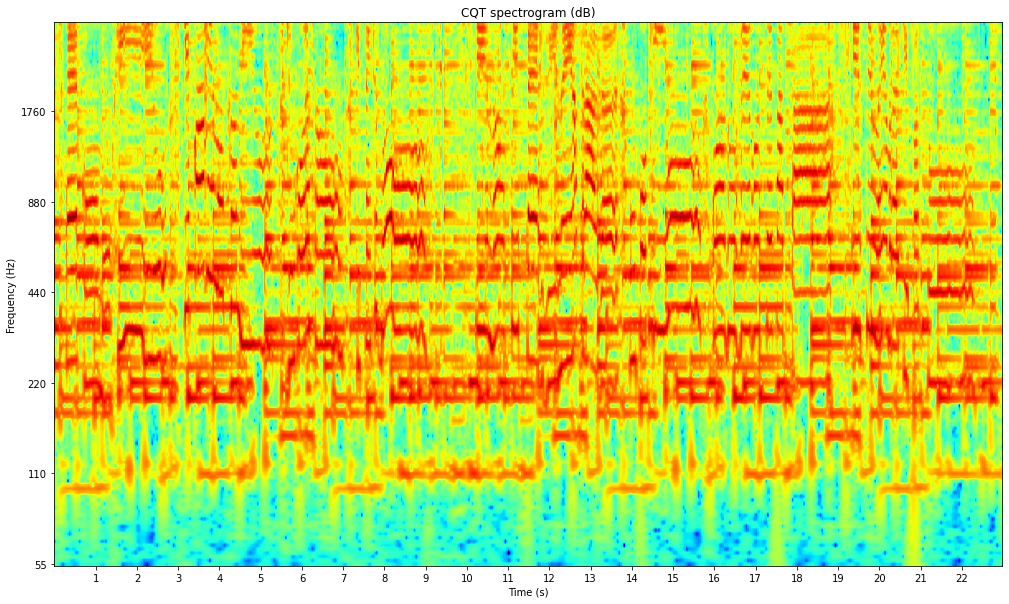

In [7]:
%matplotlib inline

# Import the needed modules
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")
audio_signal = np.mean(audio_signal, 1)

# Compute the CQT kernel using some parameters
octave_resolution = 24
minimum_frequency = 55
maximum_frequency = 3520
cqt_kernel = zaf.cqtkernel(sampling_frequency, octave_resolution, minimum_frequency, maximum_frequency)

# Compute the CQT spectrogram using the kernel
time_resolution = 25
cqt_spectrogram = zaf.cqtspectrogram(audio_signal, sampling_frequency, time_resolution, cqt_kernel)

# Display the CQT spectrogram in dB, seconds, and Hz
plt.figure(figsize=(17, 10))
zaf.cqtspecshow(cqt_spectrogram, time_resolution, octave_resolution, minimum_frequency, xtick_step=1)
plt.title("CQT spectrogram (dB)")
plt.show()

## <a id="cqtchromagram"></a>cqtchromagram

Compute the constant-Q transform (CQT) chromagram using a CQT kernel.

```
cqt_chromagram = zaf.cqtchromagram(audio_signal, sampling_frequency, time_resolution, frequency_resolution, cqt_kernel)

Inputs:
    audio_signal: audio signal (number_samples,)
    sampling_frequency: sampling frequency in Hz
    time_resolution: number of time frames per second
    octave_resolution: number of frequency channels per octave
    cqt_kernel: CQT kernel (number_frequencies, fft_length)
Output
    cqt_chromagram: CQT chromagram (number_chromas, number_times)
```

### Example: Compute and display the CQT chromagram.

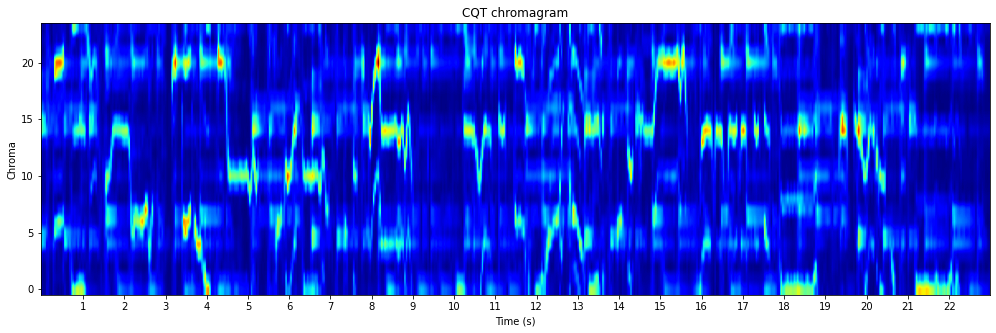

In [8]:
%matplotlib inline

# Import the needed modules
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")
audio_signal = np.mean(audio_signal, 1)

# Compute the CQT kernel using some parameters
octave_resolution4 = 24
minimum_frequency = 55
maximum_frequency = 3520
cqt_kernel = zaf.cqtkernel(sampling_frequency, octave_resolution, minimum_frequency, maximum_frequency)

# Compute the CQT chromagram
time_resolution = 25
cqt_chromagram = zaf.cqtchromagram(audio_signal, sampling_frequency, time_resolution, octave_resolution, cqt_kernel)

# Display the CQT chromagram in seconds
plt.figure(figsize=(17, 5))
zaf.cqtchromshow(cqt_chromagram, time_resolution, xtick_step=1)
plt.title("CQT chromagram")
plt.show()

## <a id="dct"></a>dct

Compute the discrete cosine transform (DCT) using the fast Fourier transform (FFT).

```
audio_dct = zaf.dct(audio_signal, dct_type)

Inputs:
    audio_signal: audio signal (window_length,)
    dct_type: dct type (1, 2, 3, or 4)
Output:
    audio_dct: audio DCT (number_frequencies,)
```

### Example: Compute the 4 different DCTs and compare them to SciPy's DCTs.

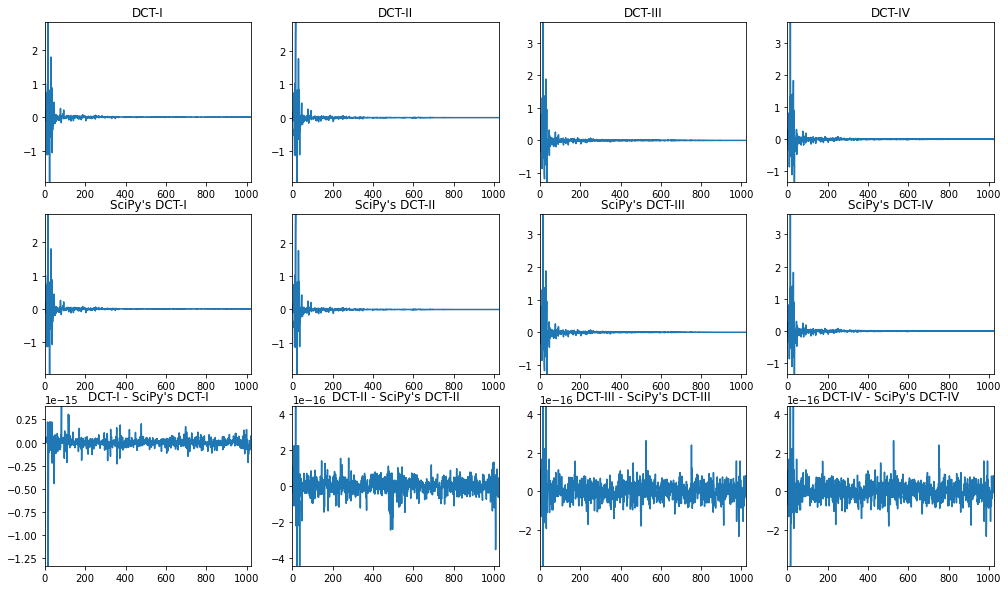

In [9]:
%matplotlib inline

# Import the needed modules
import numpy as np
import zaf
import scipy.fftpack
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")
audio_signal = np.mean(audio_signal, 1)

# Get an audio segment for a given window length
window_length = 1024
audio_segment = audio_signal[0:window_length]

# Compute the DCT-I, II, III, and IV
audio_dct1 = zaf.dct(audio_segment, 1)
audio_dct2 = zaf.dct(audio_segment, 2)
audio_dct3 = zaf.dct(audio_segment, 3)
audio_dct4 = zaf.dct(audio_segment, 4)

# Compute SciPy's DCT-I, II, III, and IV (orthogonalized)
scipy_dct1 = scipy.fftpack.dct(audio_segment, type=1, norm="ortho")
scipy_dct2 = scipy.fftpack.dct(audio_segment, type=2, norm="ortho")
scipy_dct3 = scipy.fftpack.dct(audio_segment, type=3, norm="ortho")
scipy_dct4 = scipy.fftpack.dct(audio_segment, type=4, norm="ortho")

# Plot the DCT-I, II, III, and IV, SciPy's versions, and their differences
plt.figure(figsize=(17,10))
plt.subplot(3, 4, 1), plt.plot(audio_dct1), plt.autoscale(tight=True), plt.title("DCT-I")
plt.subplot(3, 4, 2), plt.plot(audio_dct2), plt.autoscale(tight=True), plt.title("DCT-II")
plt.subplot(3, 4, 3), plt.plot(audio_dct3), plt.autoscale(tight=True), plt.title("DCT-III")
plt.subplot(3, 4, 4), plt.plot(audio_dct4), plt.autoscale(tight=True), plt.title("DCT-IV")
plt.subplot(3, 4, 5), plt.plot(scipy_dct1), plt.autoscale(tight=True), plt.title("SciPy's DCT-I")
plt.subplot(3, 4, 6), plt.plot(scipy_dct2), plt.autoscale(tight=True), plt.title("SciPy's DCT-II")
plt.subplot(3, 4, 7), plt.plot(scipy_dct3), plt.autoscale(tight=True), plt.title("SciPy's DCT-III")
plt.subplot(3, 4, 8), plt.plot(scipy_dct4), plt.autoscale(tight=True), plt.title("SciPy's DCT-IV")
plt.subplot(3, 4, 9), plt.plot(audio_dct1-scipy_dct1), plt.autoscale(tight=True), plt.title("DCT-I - SciPy's DCT-I")
plt.subplot(3, 4, 10), plt.plot(audio_dct2-scipy_dct2), plt.autoscale(tight=True), plt.title("DCT-II - SciPy's DCT-II")
plt.subplot(3, 4, 11), plt.plot(audio_dct3-scipy_dct3), plt.autoscale(tight=True), plt.title("DCT-III - SciPy's DCT-III")
plt.subplot(3, 4, 12), plt.plot(audio_dct3-scipy_dct3), plt.autoscale(tight=True), plt.title("DCT-IV - SciPy's DCT-IV")
plt.show()

## <a id="dst"></a>dst

Compute the discrete sine transform (DST) using the fast Fourier transform (FFT).

```
audio_dst = zaf.dst(audio_signal, dst_type)

Inputs:
    audio_signal: audio signal (window_length,)
    dst_type: DST type (1, 2, 3, or 4)
Output:
    audio_dst: audio DST (number_frequencies,)
```

### Example: Compute the 4 different DSTs and compare their respective inverses with the original audio.

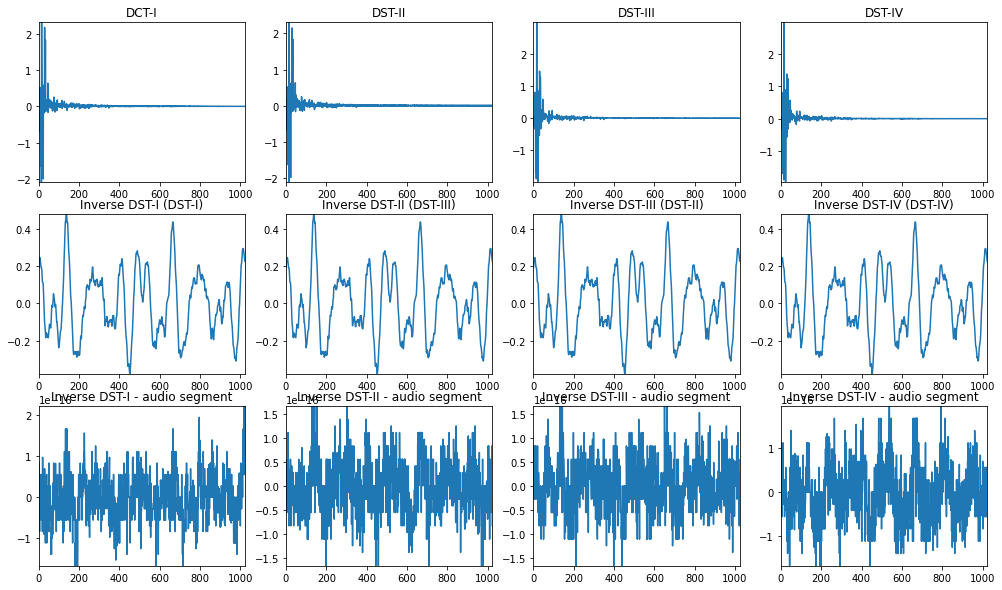

In [10]:
%matplotlib inline

# Import the needed modules
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")
audio_signal = np.mean(audio_signal, 1)

# Get an audio segment for a given window length
window_length = 1024
audio_segment = audio_signal[0:window_length]

# Compute the DST-I, II, III, and IV
audio_dst1 = zaf.dst(audio_segment, 1)
audio_dst2 = zaf.dst(audio_segment, 2)
audio_dst3 = zaf.dst(audio_segment, 3)
audio_dst4 = zaf.dst(audio_segment, 4)

# Compute their respective inverses, i.e., DST-I, II, III, and IV
audio_idst1 = zaf.dst(audio_dst1, 1)
audio_idst2 = zaf.dst(audio_dst2, 3)
audio_idst3 = zaf.dst(audio_dst3, 2)
audio_idst4 = zaf.dst(audio_dst4, 4)

# Plot the DST-I, II, III, and IV, their respective inverses, and their differences with the original audio segment
plt.figure(figsize=(17,10))
plt.subplot(3, 4, 1), plt.plot(audio_dst1), plt.autoscale(tight=True), plt.title("DCT-I")
plt.subplot(3, 4, 2), plt.plot(audio_dst2), plt.autoscale(tight=True), plt.title("DST-II")
plt.subplot(3, 4, 3), plt.plot(audio_dst3), plt.autoscale(tight=True), plt.title("DST-III")
plt.subplot(3, 4, 4), plt.plot(audio_dst4), plt.autoscale(tight=True), plt.title("DST-IV")
plt.subplot(3, 4, 5), plt.plot(audio_idst1), plt.autoscale(tight=True), plt.title("Inverse DST-I (DST-I)")
plt.subplot(3, 4, 6), plt.plot(audio_idst2), plt.autoscale(tight=True), plt.title("Inverse DST-II (DST-III)")
plt.subplot(3, 4, 7), plt.plot(audio_idst3), plt.autoscale(tight=True), plt.title("Inverse DST-III (DST-II)")
plt.subplot(3, 4, 8), plt.plot(audio_idst4), plt.autoscale(tight=True), plt.title("Inverse DST-IV (DST-IV)")
plt.subplot(3, 4, 9), plt.plot(audio_idst1-audio_segment), plt.autoscale(tight=True), plt.title("Inverse DST-I - audio segment")
plt.subplot(3, 4, 10), plt.plot(audio_idst2-audio_segment), plt.autoscale(tight=True), plt.title("Inverse DST-II - audio segment")
plt.subplot(3, 4, 11), plt.plot(audio_idst3-audio_segment), plt.autoscale(tight=True), plt.title("Inverse DST-III - audio segment")
plt.subplot(3, 4, 12), plt.plot(audio_idst4-audio_segment), plt.autoscale(tight=True), plt.title("Inverse DST-IV - audio segment")
plt.show()

## <a id="mdct"></a>mdct

Compute the modified discrete cosine transform (MDCT) using the fast Fourier transform (FFT).

```
audio_mdct = zaf.mdct(audio_signal, window_function)

Inputs:
    audio_signal: audio signal (number_samples,)
    window_function: window function (window_length,)
Output:
    audio_mdct: audio MDCT (number_frequencies, number_times)
```

### Example: Compute and display the MDCT as used in the AC-3 audio coding format.

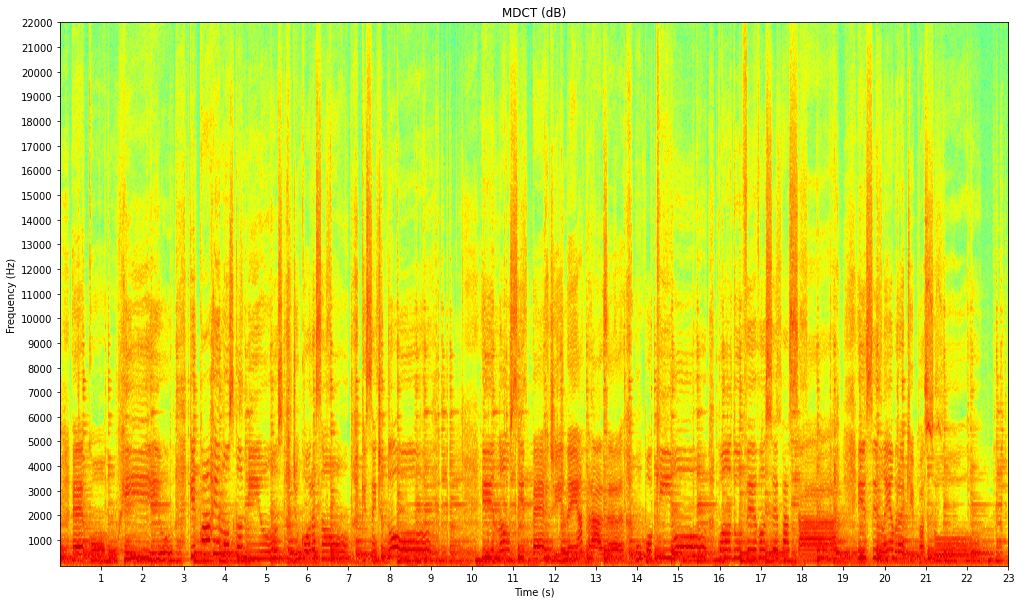

In [2]:
%matplotlib inline

# Import the needed modules
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")
audio_signal = np.mean(audio_signal, 1)

# Compute the Kaiser-Bessel-derived (KBD) window as used in the AC-3 audio coding format
window_length = 512
alpha_value = 5
window_function = np.kaiser(int(window_length/2)+1, alpha_value*np.pi)
window_function2 = np.cumsum(window_function[1:int(window_length/2)])
window_function = np.sqrt(np.concatenate((window_function2, window_function2[int(window_length/2)::-1]))
                          /np.sum(window_function))

# Compute the MDCT
audio_mdct = zaf.mdct(audio_signal, window_function)

# Display the MDCT in dB, seconds, and Hz
plt.figure(figsize=(17, 10))
zaf.specshow(np.absolute(audio_mdct), len(audio_signal), sampling_frequency, xtick_step=1, ytick_step=1000)
plt.title("MDCT (dB)")
plt.show()

## <a id="imdct"></a>imdct

Compute the inverse modified discrete cosine transform (MDCT) using the fast Fourier transform (FFT).

```
audio_signal = zaf.imdct(audio_mdct, window_function)

Inputs:
    audio_mdct: audio MDCT (number_frequencies, number_times)
    window_function: window function (window_length,)
Output:
    audio_signal: audio signal (number_samples,)
```

### Example: Verify that the MDCT is perfectly invertible.

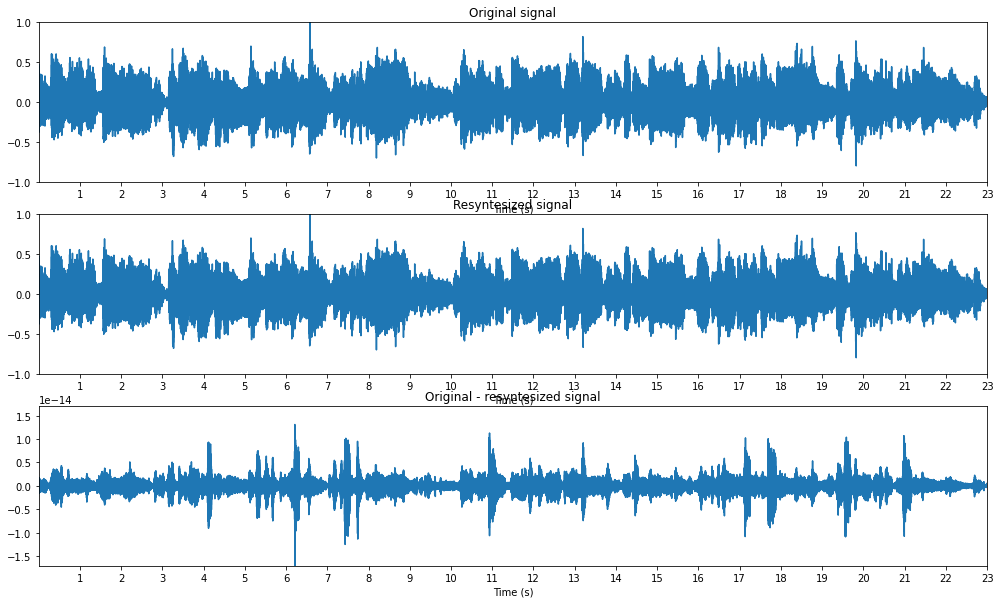

In [12]:
%matplotlib inline

# Import the needed modules
import numpy as np
import zaf
import matplotlib.pyplot as plt

# Read the audio signal (normalized) with its sampling frequency in Hz, and average it over its channels
audio_signal, sampling_frequency = zaf.wavread("audio_file.wav")
audio_signal = np.mean(audio_signal, 1)

# Compute the MDCT with a slope function as used in the Vorbis audio coding format
window_length = 2048
window_function = np.sin(np.pi/2*pow(np.sin(np.pi/window_length*np.arange(0.5, window_length+0.5)), 2))
audio_mdct = zaf.mdct(audio_signal, window_function)

# Compute the inverse MDCT
audio_signal2 = zaf.imdct(audio_mdct, window_function)
audio_signal2 = audio_signal2[0:len(audio_signal)]

# Compute the differences between the original signal and the resynthesized one
audio_differences = audio_signal-audio_signal2
y_max = np.max(np.absolute(audio_differences))

# Display the original and resynthesized signals, and their differences in seconds
plt.figure(figsize=(17, 10))
plt.subplot(3, 1, 1),
zaf.sigplot(audio_signal, sampling_frequency, xtick_step=1), plt.ylim(-1, 1), plt.title("Original signal")
plt.subplot(3, 1, 2)
zaf.sigplot(audio_signal2, sampling_frequency, xtick_step=1), plt.ylim(-1, 1), plt.title("Resyntesized signal")
plt.subplot(3, 1, 3)
zaf.sigplot(audio_differences, sampling_frequency, xtick_step=1), plt.ylim(-y_max, y_max), plt.title("Original - resyntesized signal")
plt.show()